In [ ]:
!pip install hdbscan


1.000012500156252


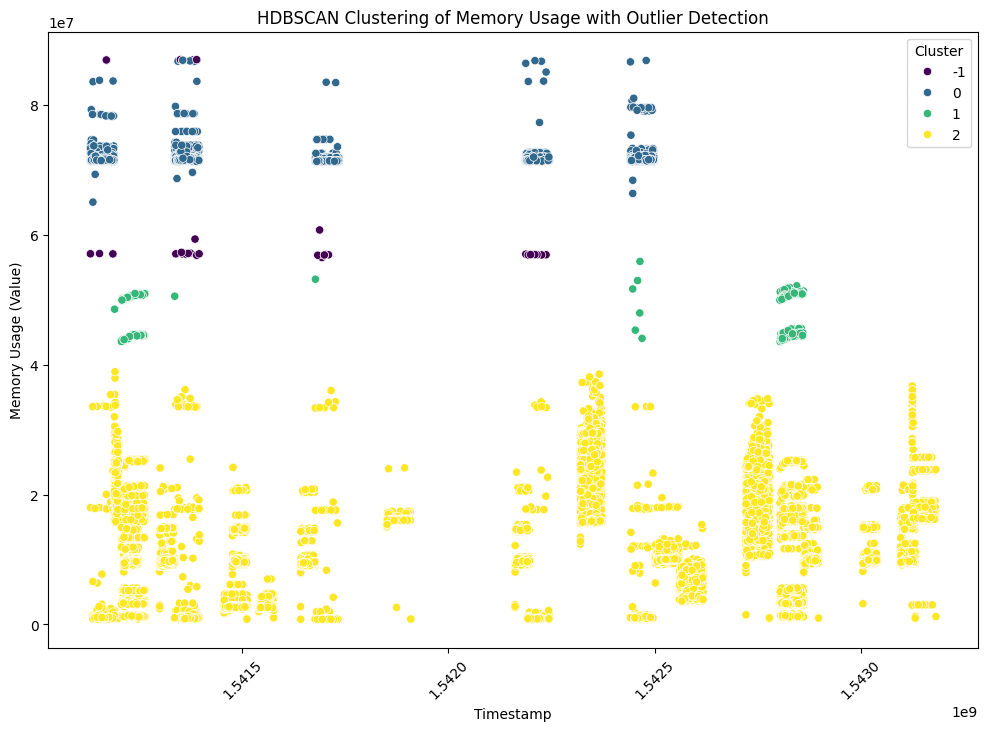

            host     jobid   timestamp       value  Cluster
9372791   gr0871  15024382  1542348150  26886488.0        2
1456534   gr1156  15018874  1541490550   9826940.0        2
16715518  gr0509  15025761  1542743760  23716068.0        2
26884878  gr0249  15008500  1541371290  71465320.0        0
10515456  gr1130  15011957  1541168940  71431440.0        0
21646770  gr1404  15018321  1541228430   9716200.0        2
17985005  gr0594  15025761  1542765060  13418080.0        2
4297304   gr1252  15011959  1541699660  71302192.0        0
16861663  gr0602  15025761  1542745500  25242876.0        2
10733529  gr0532  15020422  1542454820  71566144.0        0
Number of outliers detected: 39


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

# Load the dataset
# Here, replace this with the path to your actual large dataset

data = pd.read_csv('top_25_jobs.csv')
# 1. Sampling the Data to Reduce Memory Usage
sample_size = 80000  # Adjust sample size as needed
sample_data = data.sample(n=sample_size, random_state=42)

# 2. Scaling the 'value' Column for Clustering
scaler = StandardScaler()
sample_data['value_scaled'] = scaler.fit_transform(sample_data[['value']])

# 3. Applying HDBSCAN for Memory-Efficient Clustering
# Set parameters for HDBSCAN (adjust min_cluster_size based on desired results)
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=50, cluster_selection_epsilon=0.1)
sample_data['Cluster'] = hdbscan_clusterer.fit_predict(sample_data[['value_scaled']])
print(sample_data['value_scaled'].var())

# 4. Visualizing Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=sample_data['timestamp'], y=sample_data['value'], hue=sample_data['Cluster'], palette='viridis', marker='o')
plt.title('HDBSCAN Clustering of Memory Usage with Outlier Detection')
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage (Value)')
plt.xticks(rotation=45)
plt.legend(title="Cluster", loc="upper right")
plt.show()

# 5. Analyzing Clusters
# Display sample of clustered data to understand which clusters were formed
print(sample_data[['host', 'jobid', 'timestamp', 'value', 'Cluster']].head(10))

# 6. Checking Number of Outliers
# In HDBSCAN, outliers are labeled as -1, similar to DBSCAN
n_outliers = (sample_data['Cluster'] == -1).sum()
print(f"Number of outliers detected: {n_outliers}")

# 7. Save the Sample Data with Cluster Labels (optional)
# Saves to a new CSV file, useful for further analysis
sample_data.to_csv('hdbscan_sample_data_with_clusters.csv', index=False)


HDBSCAN with MDS

In [2]:
# Ensure timestamp is in datetime format
# sample_data['timestamp'] = pd.to_datetime(sample_data['timestamp'])
# Convert to datetime, assuming timestamps are in nanoseconds (likely for the issue here)
# Correct the conversion to datetime, assuming timestamps are in seconds
sample_data['timestamp'] = pd.to_datetime(sample_data['timestamp'], unit='s', errors='coerce')

# Extract the hour again
sample_data['hour'] = sample_data['timestamp'].dt.hour

print(sample_data['timestamp'].head())
# Extract the hour again

# Extract temporal features
sample_data['hour'] = sample_data['timestamp'].dt.hour  # Hour of the day
sample_data['day_of_week'] = sample_data['timestamp'].dt.day_name()  # Day of the week
sample_data['week'] = sample_data['timestamp'].dt.isocalendar().week  # Week number


9372791    2018-11-16 06:02:30
1456534    2018-11-06 07:49:10
16715518   2018-11-20 19:56:00
26884878   2018-11-04 22:41:30
10515456   2018-11-02 14:29:00
Name: timestamp, dtype: datetime64[ns]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
    hour  Cluster  avg_memory_usage  job_count
0      0        0      7.154693e+07        723
1      0        1      4.650058e+07          7
2      0        2      1.334552e+07       2290
3      1       -1      8.689582e+07          1
4      1        0      7.161485e+07        595
..   ...      ...               ...        ...
87    22        2      1.476568e+07       3004
88    23       -1      5.703894e+07          2
89    23        0      7.157010e+07        955
90    23        1      4.892463e+07         12
91    23        2      1.256483e+07       2531

[92 rows x 4 columns]
                   timestamp  hour
9372791  2018-11-16 06:02:30     6
1456534  2018-11-06 07:49:10     7
16715518 2018-11-20 19:56:00    19
26884878 2018-11-04 22:41:30    22
10515456 2018-11-02 14:29:00    14


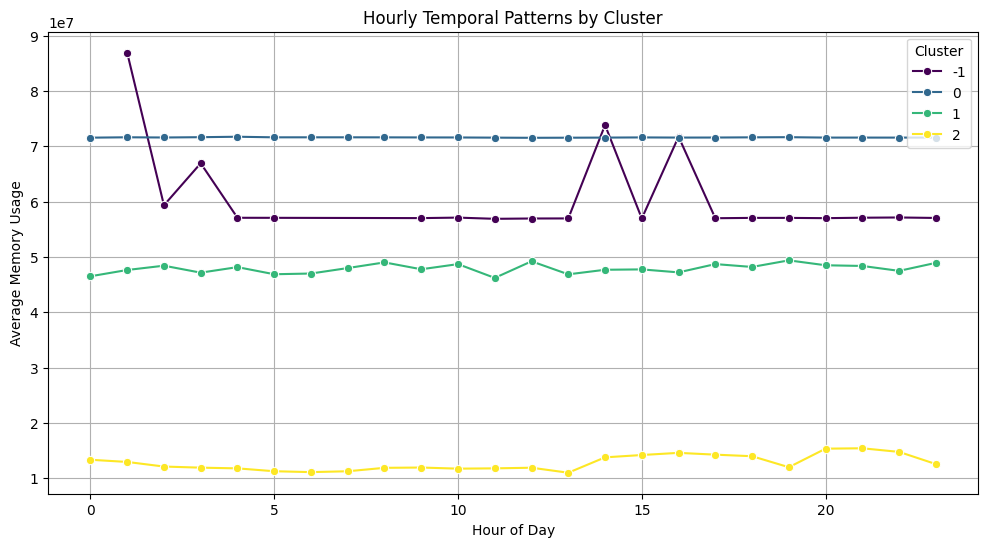

In [4]:
# Aggregate by hour and cluster
hourly_data = sample_data.groupby(['hour', 'Cluster']).agg(
    avg_memory_usage=('value', 'mean'),
    job_count=('value', 'size')
).reset_index()

print(hourly_data['hour'].unique())
print(hourly_data)
print(sample_data[['timestamp', 'hour']].head())


# Plot hourly trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_data, x='hour', y='avg_memory_usage', hue='Cluster', palette='viridis', marker='o')
plt.title('Hourly Temporal Patterns by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Average Memory Usage')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


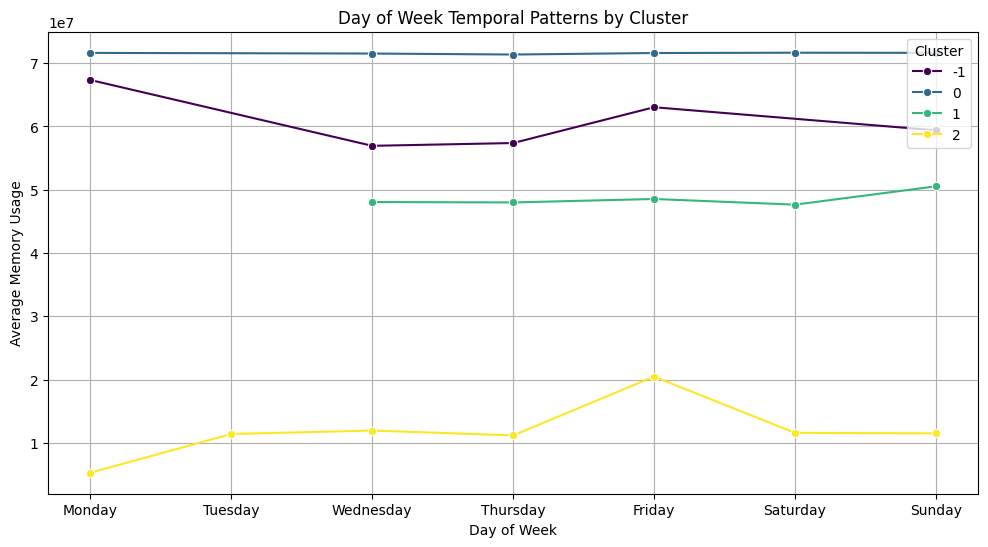

In [5]:
# Aggregate by day of week and cluster
day_of_week_data = sample_data.groupby(['day_of_week', 'Cluster']).agg(
    avg_memory_usage=('value', 'mean'),
    job_count=('value', 'size')
).reset_index()

# Ensure days are ordered correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_data['day_of_week'] = pd.Categorical(day_of_week_data['day_of_week'], categories=day_order, ordered=True)

# Plot day-of-week trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=day_of_week_data, x='day_of_week', y='avg_memory_usage', hue='Cluster', palette='viridis', marker='o')
plt.title('Day of Week Temporal Patterns by Cluster')
plt.xlabel('Day of Week')
plt.ylabel('Average Memory Usage')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


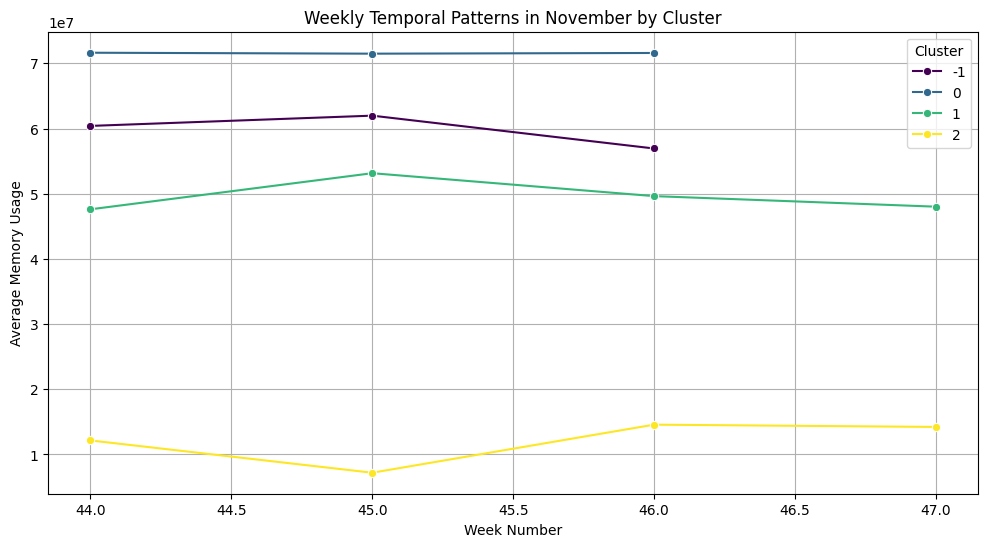

In [6]:
# Filter data for November
november_data = sample_data[sample_data['timestamp'].dt.month == 11]

# Aggregate by week and cluster
weekly_data = november_data.groupby(['week', 'Cluster']).agg(
    avg_memory_usage=('value', 'mean'),
    job_count=('value', 'size')
).reset_index()

# Plot weekly trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_data, x='week', y='avg_memory_usage', hue='Cluster', palette='viridis', marker='o')
plt.title('Weekly Temporal Patterns in November by Cluster')
plt.xlabel('Week Number')
plt.ylabel('Average Memory Usage')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


Cluster Summary:
   Cluster  avg_memory_usage  std_memory_usage  job_count
0       -1      6.021882e+07      9.175472e+06         39
1        0      7.157927e+07      6.852264e+05      19957
2        1      4.783323e+07      3.168807e+06        450
3        2      1.256992e+07      7.214791e+06      59554


C:\Users\kruth\AppData\Local\Temp\ipykernel_9884\2730087526.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=sample_data, x='Cluster', y='value', palette='Set2', jitter=True, alpha=0.6)


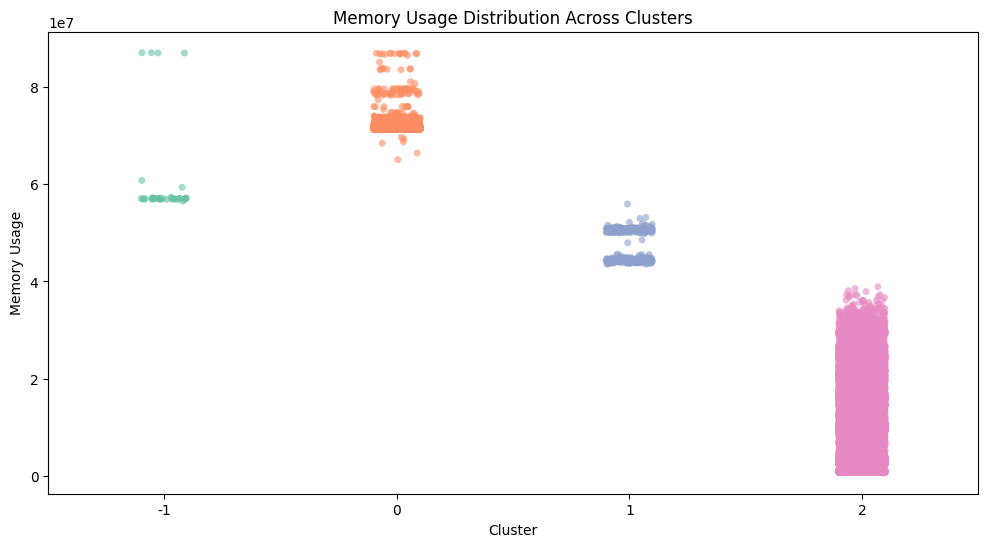

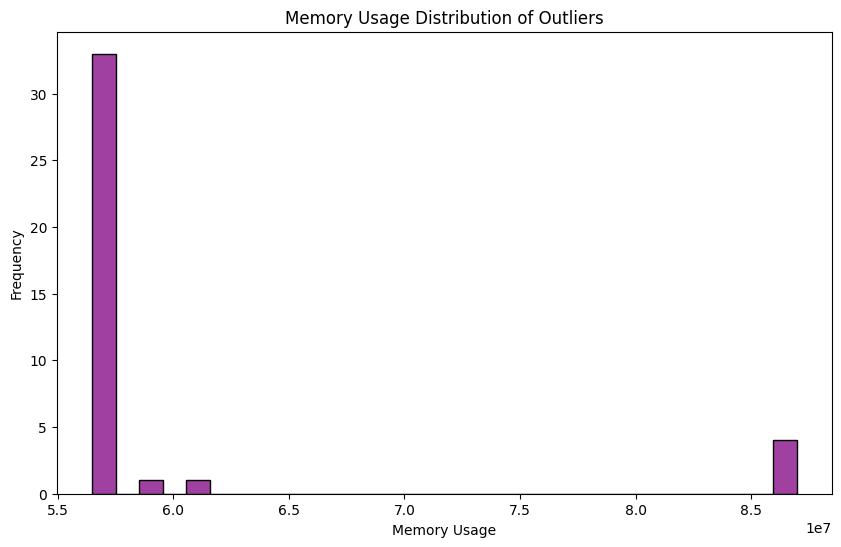

             jobid  Cluster Resource_Category
9372791   15024382        2      Low Resource
1456534   15018874        2      Low Resource
16715518  15025761        2      Low Resource
26884878  15008500        0     High Resource
10515456  15011957        0     High Resource


C:\Users\kruth\AppData\Local\Temp\ipykernel_9884\2730087526.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sample_data, x='Resource_Category', palette='Set2')


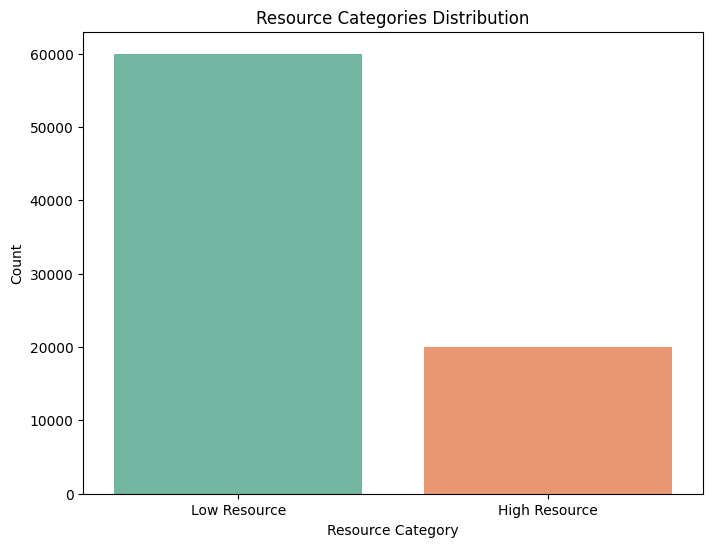

In [8]:
cluster_summary = sample_data.groupby('Cluster').agg(
    avg_memory_usage=('value', 'mean'),
    std_memory_usage=('value', 'std'),
    job_count=('jobid', 'count')
).reset_index()

print("Cluster Summary:")
print(cluster_summary)


plt.figure(figsize=(12, 6))
sns.stripplot(data=sample_data, x='Cluster', y='value', palette='Set2', jitter=True, alpha=0.6)
plt.title('Memory Usage Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Memory Usage')
plt.show()


outliers = sample_data[sample_data['Cluster'] == -1]

plt.figure(figsize=(10, 6))
sns.histplot(outliers['value'], bins=30, kde=False, color='purple')
plt.title('Memory Usage Distribution of Outliers')
plt.xlabel('Memory Usage')
plt.ylabel('Frequency')
plt.show()





memory_threshold = sample_data['value'].quantile(0.75)  # Top 20% as "high memory"
sample_data['Resource_Category'] = sample_data['value'].apply(
    lambda x: 'High Resource' if x > memory_threshold else 'Low Resource'
)
print(sample_data[['jobid', 'Cluster', 'Resource_Category']].head())


plt.figure(figsize=(8, 6))
sns.countplot(data=sample_data, x='Resource_Category', palette='Set2')
plt.title('Resource Categories Distribution')
plt.xlabel('Resource Category')
plt.ylabel('Count')
plt.show()



### **Actionable Insights**
1. **Investigate Outliers**:
   - Determine if outliers indicate inefficiencies or unusual workloads.
2. **Optimize Resources**:
   - Focus on clusters with high memory usage to optimize job allocation.
3. **Validate Cluster Definitions**:
   - Check if clusters align with expected patterns or indicate anomalies.
4. **Explore Time-Based Trends**:
   - Look for periodic or seasonal memory usage trends in your data.


HDBSCAN with MDS

In [ ]:
# from sklearn.manifold import MDS

# # Convert timestamp to datetime
# data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s', errors='coerce')

# # Aggregate Job Statistics
# job_stats = data.groupby('jobid').agg(
#     job_duration=('timestamp', lambda x: (x.max() - x.min()).total_seconds() / 3600),  # Duration in hours
#     avg_memory_usage=('value', 'mean'),  # Average memory usage
#     std_memory_usage=('value', 'std'),   # Standard deviation of memory usage
#     max_memory_usage=('value', 'max')    # Peak (max) memory usage
# ).fillna(0).reset_index()



# # Step 2: Scale Features
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(
#     job_stats[['job_duration', 'avg_memory_usage', 'std_memory_usage', 'max_memory_usage']]
# )


# # 3. Applying HDBSCAN for Memory-Efficient Clustering
# # Set parameters for HDBSCAN (adjust min_cluster_size based on desired results)
# hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=50, cluster_selection_epsilon=0.1)
# sample_data['Cluster'] = hdbscan_clusterer.fit_predict(sample_data[['value_scaled']])
# print(sample_data['value_scaled'].var())

# # Step 3: Apply HDBSCAN for Clustering
# # hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=600, min_samples=100, cluster_selection_epsilon=0.1)
# # job_stats['Cluster'] = hdbscan_clusterer.fit_predict(scaled_features)

# # Step 4: Apply MDS for 2D Visualization
# mds = MDS(n_components=2, random_state=42)
# mds_result = mds.fit_transform(scaled_features)

# # Add MDS results to the DataFrame
# sample_data['MDS1'] = mds_result[:, 0]
# sample_data['MDS2'] = mds_result[:, 1]
# # Step 5: Visualize Clusters in MDS Space
# plt.figure(figsize=(10, 8))
# sns.scatterplot(data=sample_data, x='MDS1', y='MDS2', hue='Cluster', palette='viridis', s=50, alpha=0.7)
# plt.title('HDBSCAN Clustering in MDS Space')
# plt.xlabel('MDS Dimension 1')
# plt.ylabel('MDS Dimension 2')
# plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
# plt.show()


# # Step 7: Analyze and Display Clusters
# print(sample_data[['jobid', 'job_duration', 'avg_memory_usage', 'std_memory_usage', 'max_memory_usage', 'Cluster']])

# # Step 8: Count Outliers
# n_outliers = (job_stats['Cluster'] == -1).sum()
# print(f"Number of outliers detected with HDBSCAN: {n_outliers}")


1.000012500156252


c:\Users\kruth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


ValueError: Length of values (25) does not match length of index (80000)

# **GMM Model**

         jobid  job_duration  avg_memory_usage  std_memory_usage  \
0     15008500     25.997222      6.519248e+07      2.008973e+07   
1     15010685      0.000000      7.681167e+06      4.445844e+05   
2     15010686    215.763889      7.822645e+06      6.437399e+05   
3     15010687    539.688889      7.518873e+06      3.959411e+05   
4     15011140      0.000000      7.793340e+06      3.653663e+05   
...        ...           ...               ...               ...   
7534  16000088      0.000000      7.426520e+05      0.000000e+00   
7535  16000090      0.000000      7.345680e+05      0.000000e+00   
7536  16000091      0.000000      7.376840e+05      7.014499e+02   
7537  16000092      0.000000      7.406359e+05      5.407486e+03   
7538  16000096      0.000000      9.628351e+05      4.002688e+05   

      max_memory_usage  num_records  
0           89040984.0      1349659  
1            9535296.0       237206  
2           12190172.0       237872  
3            8117412.0       20

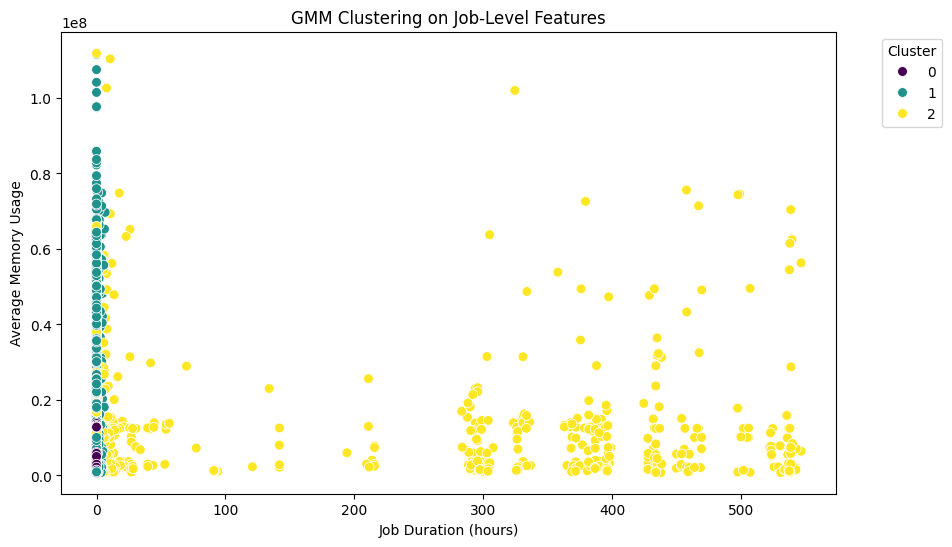

Cluster Summary:
   Cluster  avg_job_duration  avg_memory_usage  std_memory_usage  \
0        0          0.003640      7.609268e+06      8.640380e+05   
1        1          0.433973      1.524855e+07      6.008832e+06   
2        2        170.009241      1.233961e+07      3.135446e+06   

   max_memory_usage  avg_num_records  job_count  
0      8.656627e+06       459.393532       4762  
1      2.815855e+07     12203.192629       2035  
2      2.063646e+07    139150.784367        742  
Processed data with GMM clusters saved to 'job_stats_with_gmm_clusters.csv'


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (update file path as needed)
# Assuming the dataset is already loaded in the variable `data`

# Step 1: Filter rows with valid `jobid`
# filtered_data = data[data['jobid'] > 0].copy()

 #from previous steps
data1 = pd.read_csv('combined_grizzly_meminfo_active.csv')
# Step 1: Ensure `timestamp` is in datetime format
data1['timestamp'] = pd.to_datetime(data['timestamp'])

data1 = data1[data1['jobid'] > 0].copy()
# Step 2: Aggregate data to compute job-level statistics
job_stats = data1.groupby('jobid').agg(
    job_duration=('timestamp', lambda x: (x.max() - x.min()).total_seconds() / 3600),  # Duration in hours
    avg_memory_usage=('value', 'mean'),  # Average memory usage
    std_memory_usage=('value', 'std'),   # Standard deviation of memory usage
    max_memory_usage=('value', 'max'),  # Peak (max) memory usage
    num_records=('value', 'count')  # Number of records per job
).fillna(0).reset_index()

print(job_stats)
# Step 3: Filter out jobs with extreme outliers or insufficient data
# job_stats = job_stats[
#     (job_stats['job_duration'] > 0.01) &  # Jobs with a duration > 0.1 hour
#     (job_stats['avg_memory_usage'] > 1e4) &  # Average memory usage > 1MB
#     (job_stats['std_memory_usage'] > 1e2)  # Standard deviation > 10KB
# ]

# Step 4: Scale features for GMM clustering
features = ['job_duration', 'avg_memory_usage', 'std_memory_usage', 'max_memory_usage', 'num_records']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(job_stats[features])

# Step 5: Apply Gaussian Mixture Model (GMM) for clustering
n_components = 3  # Adjust the number of clusters as needed
gmm = GaussianMixture(n_components=n_components, random_state=42)
job_stats['Cluster'] = gmm.fit_predict(scaled_features)

# Step 6: Visualize clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=job_stats['job_duration'], 
    y=job_stats['avg_memory_usage'], 
    hue=job_stats['Cluster'], 
    palette='viridis', 
    s=50
)
plt.title('GMM Clustering on Job-Level Features')
plt.xlabel('Job Duration (hours)')
plt.ylabel('Average Memory Usage')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Step 7: Summarize clusters for analysis
cluster_summary = job_stats.groupby('Cluster').agg(
    avg_job_duration=('job_duration', 'mean'),
    avg_memory_usage=('avg_memory_usage', 'mean'),
    std_memory_usage=('std_memory_usage', 'mean'),
    max_memory_usage=('max_memory_usage', 'mean'),
    avg_num_records=('num_records', 'mean'),
    job_count=('Cluster', 'size')
).reset_index()

print("Cluster Summary:")
print(cluster_summary)




# Step 8: Save the processed dataset with clusters
job_stats.to_csv('job_stats_with_gmm_clusters.csv', index=False)
print("Processed data with GMM clusters saved to 'job_stats_with_gmm_clusters.csv'")


C:\Users\kruth\AppData\Local\Temp\ipykernel_9884\4282337357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


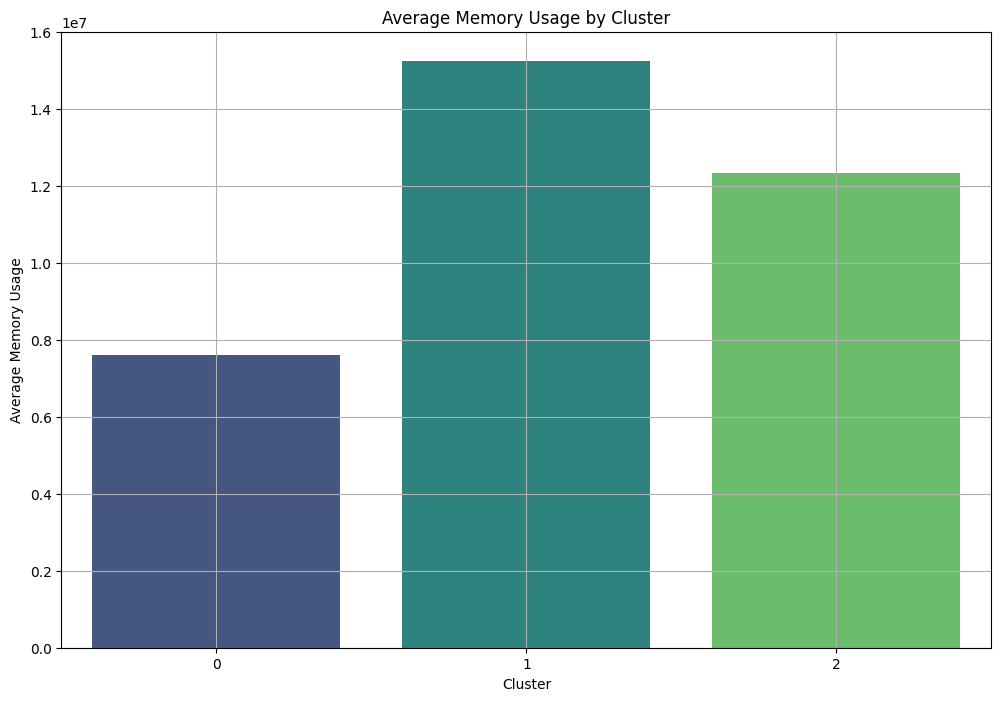

In [19]:
plt.figure(figsize=(12, 8))

# Aggregate data for bar plot
cluster_means = job_stats.groupby('Cluster')['avg_memory_usage'].mean().reset_index()

# Create a bar plot
sns.barplot(
    x=cluster_means['Cluster'], 
    y=cluster_means['avg_memory_usage'], 
    palette='viridis'
)

# Set titles and labels
plt.title('Average Memory Usage by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Memory Usage')
plt.grid(True)
plt.show()


C:\Users\kruth\AppData\Local\Temp\ipykernel_9884\3386806780.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=job_stats, x='Cluster', palette='viridis')


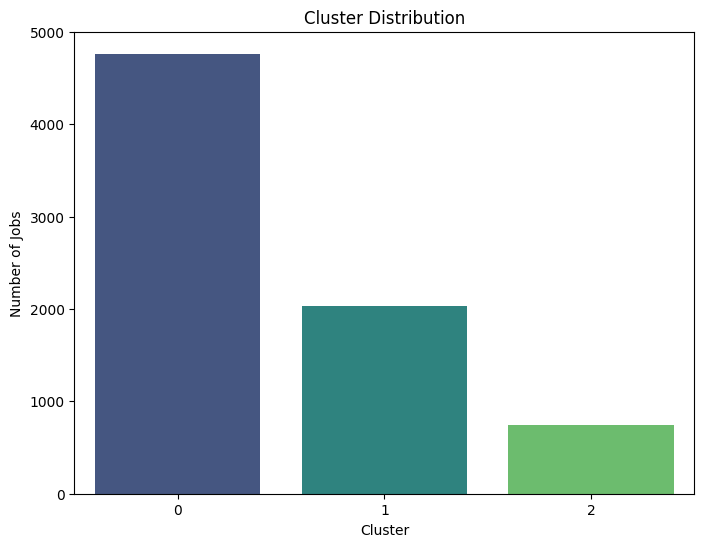

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(data=job_stats, x='Cluster', palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Jobs')
plt.show()


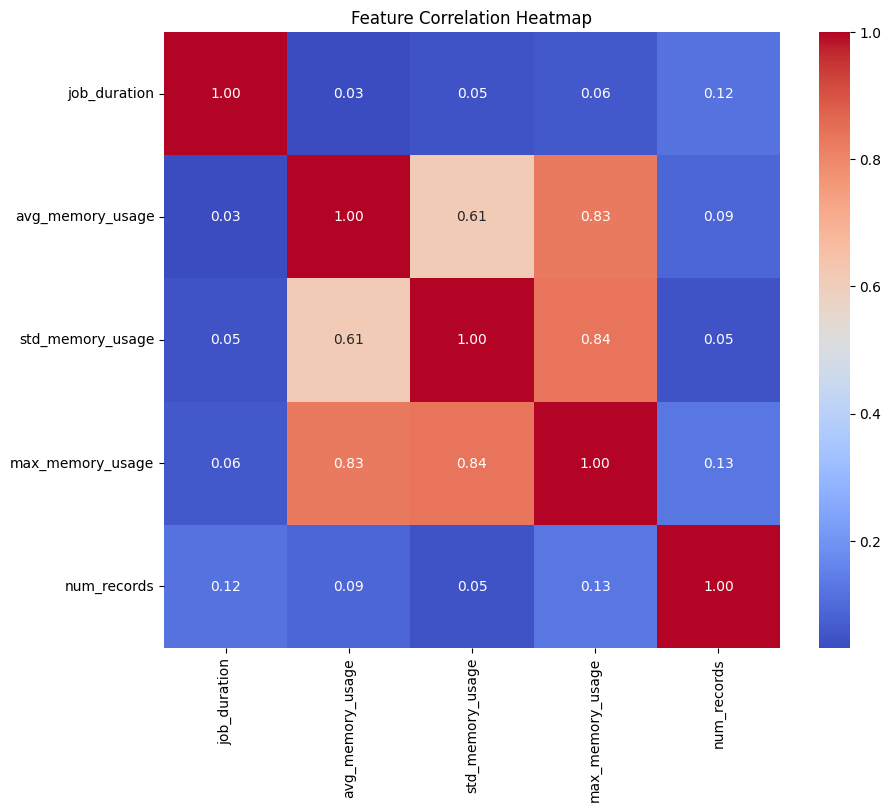

In [26]:
# Compute correlation matrix
corr_matrix = job_stats[['job_duration', 'avg_memory_usage', 'std_memory_usage', 'max_memory_usage', 'num_records']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()


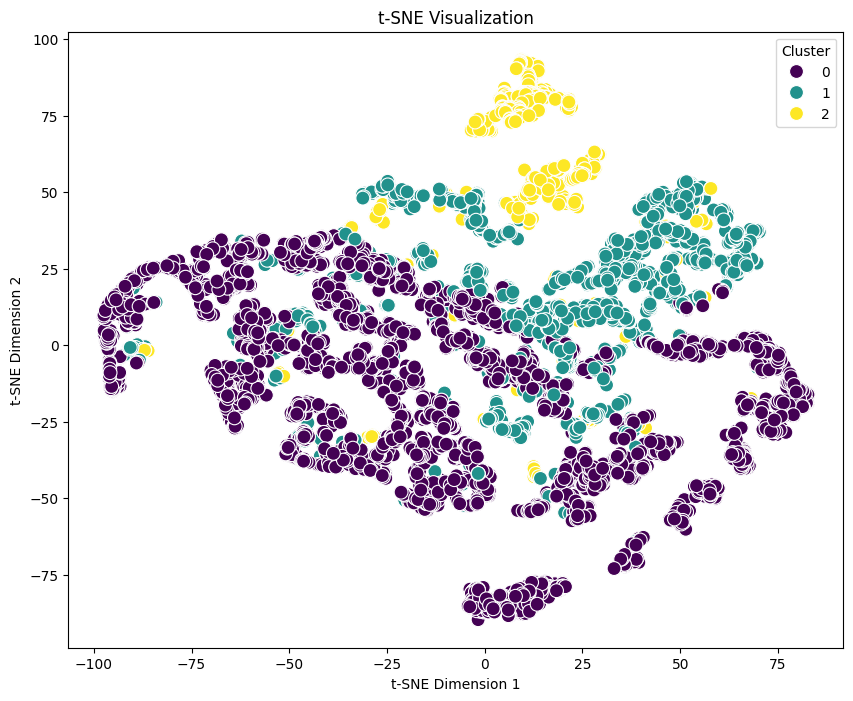

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(scaled_features)

# Visualize t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=job_stats['Cluster'], palette='viridis', s=100)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()


Data description and some PCA to understand data

     host     jobid                     timestamp       value
0  gr0744  15011958 1970-01-01 00:00:01.541386820  71459528.0
1  gr0744  15011958 1970-01-01 00:00:01.541386830  71459528.0
2  gr0744  15011958 1970-01-01 00:00:01.541386840  71459528.0
3  gr0744  15011958 1970-01-01 00:00:01.541386850  71459528.0
4  gr0744  15011958 1970-01-01 00:00:01.541386860  71459552.0
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27673012 entries, 0 to 27673011
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   host       object        
 1   jobid      int64         
 2   timestamp  datetime64[ns]
 3   value      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 844.5+ MB
None

Summary Statistics:
              jobid                      timestamp         value
count  2.767301e+07                       27673012  2.767301e+07
mean   1.502055e+07  1970-01-01 00:00:01.542121222  2.736715e+07
min

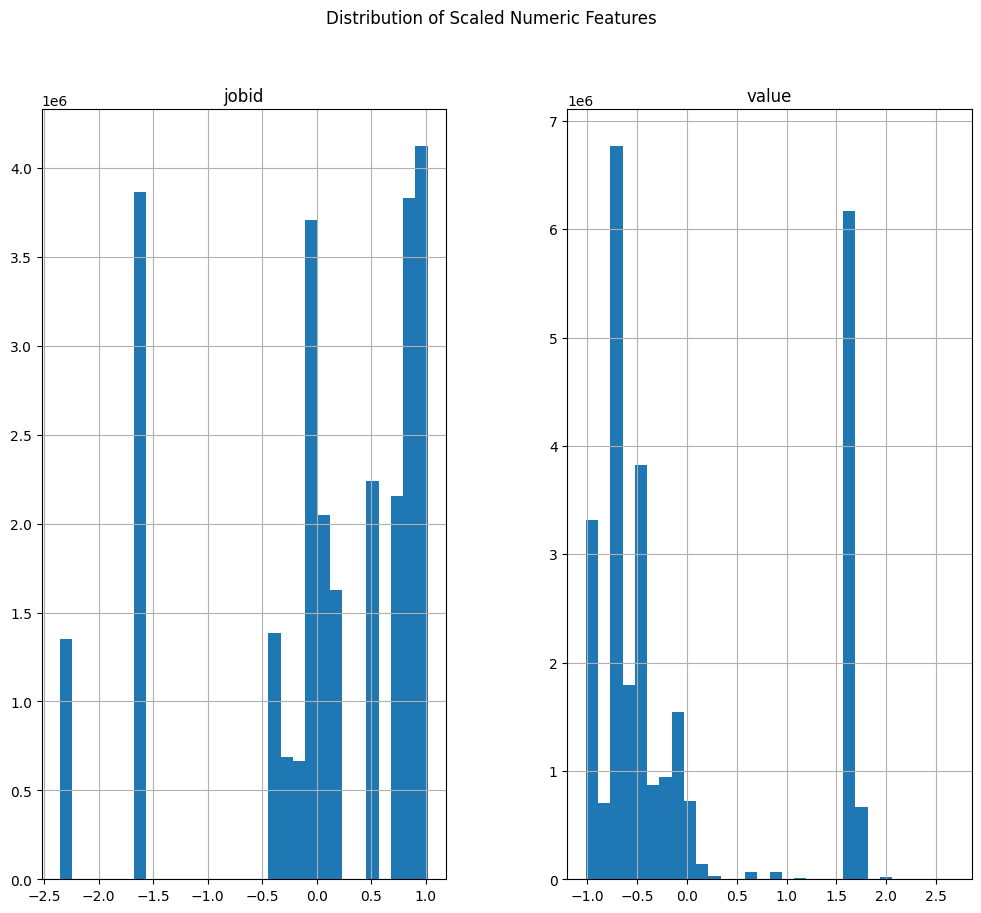


Correlation Matrix:


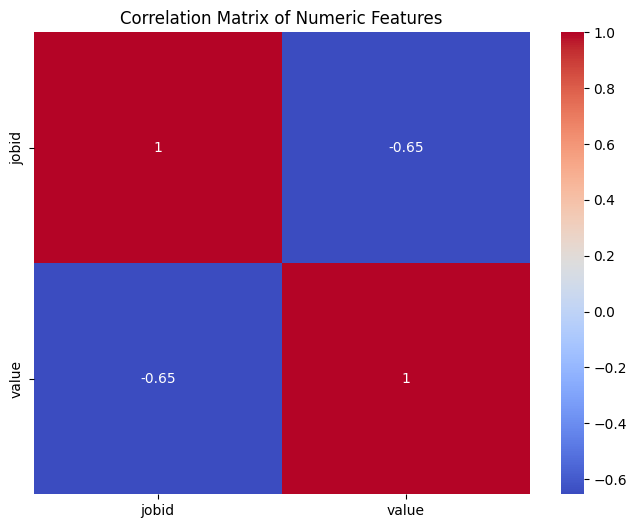


Explained Variance by First 2 Principal Components: 1.00


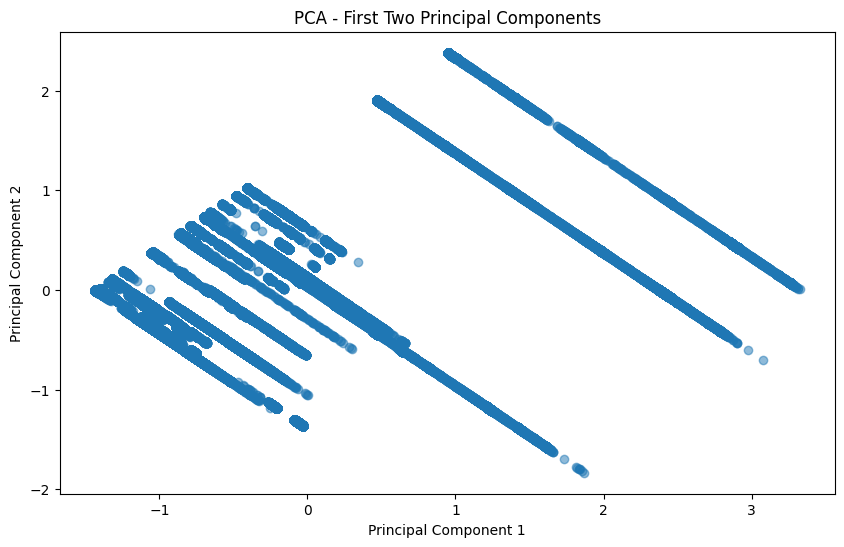

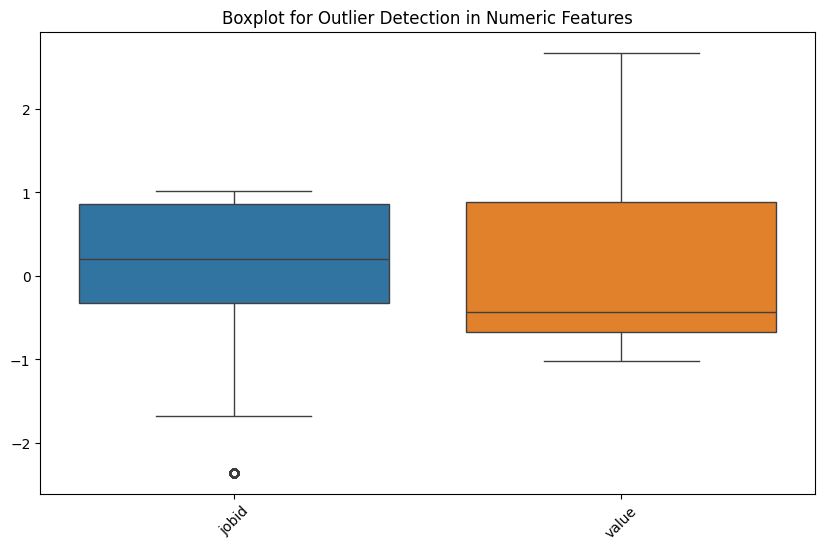


Data Sparsity: 0.00%

Summary:
1. Number of Numeric Features: 2
2. Number of Categorical Features: 2
3. Approximate Data Sparsity: 0.00%
4. Explained Variance (PCA, 2 components): 1.00
5. Correlation Matrix:
          jobid     value
jobid  1.000000 -0.654506
value -0.654506  1.000000


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

# Load the dataset
data = pd.read_csv('top_25_jobs.csv')
# Step 1: Ensure `timestamp` is in datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# file_path = 'top_25_jobs.csv'
# data = pd.read_csv(file_path)

data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
print(data.head(5))
data = data[data['jobid'] > 0].copy()

# data = data[data['jobid'] != 0].copy()


# Load your dataset (replace 'your_dataset.csv' with your file)

# 1. Basic Information
print("Dataset Information:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())
print("\nMissing Values per Column:")
print(data.isnull().sum())

# 2. Check Data Types
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = data.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"\nNumeric Features: {numeric_features}")
print(f"Categorical Features: {categorical_features}")

# 3. Unique Values for Categorical Variables
print("\nUnique Values in Categorical Features:")
for col in categorical_features:
    print(f"{col}: {data[col].nunique()} unique values")

# 4. Scale Numeric Features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numeric_features])
scaled_df = pd.DataFrame(scaled_data, columns=numeric_features)

# 5. Plot Distributions of Numeric Features
print("\nDistribution of Numeric Features:")
scaled_df.hist(bins=30, figsize=(12, 10))
plt.suptitle("Distribution of Scaled Numeric Features")
plt.show()

# 6. Check Correlations Between Numeric Features
print("\nCorrelation Matrix:")
correlation_matrix = scaled_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# 7. Dimensionality Reduction (PCA) for High-Dimensional Data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"\nExplained Variance by First 2 Principal Components: {explained_variance:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title("PCA - First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 8. Density Plot for Outlier Detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=scaled_df)
plt.title("Boxplot for Outlier Detection in Numeric Features")
plt.xticks(rotation=45)
plt.show()

# 9. Check Data Sparsity (for high-dimensional datasets)
sparsity = 1.0 - (np.count_nonzero(scaled_data) / float(scaled_data.size))
print(f"\nData Sparsity: {sparsity:.2%}")


# Summary of Characteristics to Consider
print("\nSummary:")
print(f"1. Number of Numeric Features: {len(numeric_features)}")
print(f"2. Number of Categorical Features: {len(categorical_features)}")
print(f"3. Approximate Data Sparsity: {sparsity:.2%}")
print(f"4. Explained Variance (PCA, 2 components): {explained_variance:.2f}")
print("5. Correlation Matrix:")
print(correlation_matrix)
